<a href="https://colab.research.google.com/github/rosselladedo/DOG_BREEDS_SEARCH_ENGINE/blob/main/mAPPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import numpy as np
import time
import itertools
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import traceback
import sys
import sklearn
import pathlib
import random as rand

from IPython.display import display
from ipywidgets import HBox, Image, HTML

from sklearn import metrics
from sklearn.preprocessing import normalize
from collections import OrderedDict
from random import random
from ipywidgets import Image
from numpy.linalg import norm
from IPython.display import display
from keras.models import Model
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.auto import tqdm
from PIL import Image, ImageDraw

# tensorflow version 2.4.0
from tensorflow import keras

In [3]:
DOGS_BREEDS = 120
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES= 120

In [4]:
#data loading
BASE_DIR = "/content/gdrive/Shareddrives/MIRCV"
IMAGES_DIR = "/content/gdrive/MyDrive/MIRCV"
FEATURES_CONCATENATE_DIR = "/content/gdrive/Shareddrives/Dataset/Features/features_fintuned_concatenate_predict.npz"
TEST_PATH = os.path.join(BASE_DIR, "TestSet")

DOGS_IMAGES_DIRECTORIES_PATH = os.path.join(IMAGES_DIR, "images/Images")
ALL_IMAGES_DIR = "/content/gdrive/Shareddrives/MIRCV/All_Images"
NOISE_DIR = "/content/gdrive/Shareddrives/Dataset/mirflickr25k/mirflickr"

# **UTILITY FUNCTIONS**

In [5]:
#FUNCTION TO DISPLAY RESULTS

def unpad_image(image_pil):
  """ Removes white borders of the given PIL Image. """
  image_np = np.array(image_pil)
  rr, cc = np.nonzero((image_np != 255).any(axis=2))
  y0, y1 = rr.min(), rr.max()
  x0, x1 = cc.min(), cc.max()
  return image_pil.crop((x0, y0, x1, y1))


def make_image_grid(image_paths, relevance=None, rows=1, cols=8, thumbnail_size=(100, 100)):
  """ Makes a grid of images.
  Args:
    - image_paths (list): a list of image paths
    - relevance (list): if not None, indicates whether to add a green or red
                        indicator on each image.
    - rows, cols (int): the number of rows/cols of the image grid.
    - thumbnail_size (tuple): size of a cell as a (width, height) tuple.
  Returns:
    - grid (PIL.Image): the grid as a PIL Image.
  """
  cell_width, cell_height = thumbnail_size
  grid = Image.new('RGB', (cell_width * cols, cell_height * rows), color='white')
  draw = ImageDraw.Draw(grid)
  relevance = (None,) * len(image_paths) if relevance is None else relevance

  cells = itertools.product(range(rows), range(cols))  # every (row, col) combination
  for (row, col), image_path, rel in zip(cells, image_paths, relevance):
    if not os.path.exists(image_path):
      image_path = os.path.join(NOISE_DIR, image_path.split('/')[6])
    image_pil = Image.open(image_path).convert('RGB')
    image_pil = unpad_image(image_pil)
    image_pil.thumbnail(thumbnail_size)

    cell_x = cell_width * col + (cell_width - image_pil.width) // 2
    cell_y = cell_height * row + (cell_height - image_pil.height) // 2
    grid.paste(image_pil, (cell_x, cell_y))

    if rel is not None:
      color = 'green' if rel else 'red'
      x0 = cell_width * col + 5
      y0 = cell_height * (row + 1) - 3
      x1 = cell_width * (col + 1) - 5
      y1 = cell_height * (row + 1)
      draw.rectangle([x0, y0, x1, y1], fill=color)

  return grid

def display_results(query_image, ranks, mAP_vector, limit=10):
  """ Draws results of image searches.
  Args:
    - ranks (ndarray): a (Q,N)-shaped matrix of indices of retrieved elements
                       for each query, already ranked. E.g., ranks[0, 4] is the
                       index of fifth retrieved element with respect to query #0.
    - groundtruth (ndarray): a (Q,N)-shaped boolean matrix indicating relevance
                             of database elements to queries, i.e., if
                             groundtruth[3,2] is True, then the database element
                             #2 is relevant to the query #3.
    - queries_annot (pandas.DataFrame): information about queries.
    - db_annot (pandas.DataFrame): information about database elements.
    - limit (int): the number of top results to show.
  """
  
  nq = len(ranks)
  image_paths = []
  image_relevance = []

  image_paths.append(os.path.join(TEST_PATH, query_image))
  image_relevance.append( None )
  
  counter = 0

  for rank in ranks:

    image_paths.append(os.path.join(ALL_IMAGES_DIR, rank[1]))
    image_relevance.append(mAP_vector[counter])

    counter = counter + 1

  grid = make_image_grid(image_paths, image_relevance, rows=nq, cols=limit+1)
  display(grid)

In [6]:
def return_rank_mAP(query, rank):
  mAP_vector = []
  query_label = query.split("_")[0]

  for dog in rank:
    result_label = dog[1].split("_")[0]
    if query_label == result_label:
      mAP_vector.append(1)
    else:
      mAP_vector.append(0)
      
  return mAP_vector

In [7]:
def mAP_calculation(res, query_img, num_dogs_performance = 5):
  query_label = query_img.split("_")[0]
  results = res
  
  denom = num_dogs_performance

  mAP = 0

  for r in results:

    if num_dogs_performance == 0:
      break
    if r == None:
      break

    result_label = r[1].split("_")[0]
    #print(result_label)

    if query_label == result_label:
      mAP = mAP + 1

    num_dogs_performance = num_dogs_performance -1

  mAP = mAP/denom
  
  return mAP

In [8]:
def generate_mean_vector(features_vector):
  mean_vector = []
  for feat in tqdm(features_vector):
    f = feat[1]
    mean_vector.append(f)
  
  mean_vector = np.mean(mean_vector, axis = 0)
  return mean_vector

In [9]:
def generate_binary_vector(mean_vector, features_vector):
  #features_vector = features_vector[0]
  features_vector = features_vector[0][1][0]
  mean_vector = mean_vector[0]
  binary_vector = [0 if features_vector[i] < mean_vector[i] else 1 for i in range(len(features_vector))]

  return np.asarray(binary_vector)

In [10]:
#funzione per ordinare i risultati della query dal più "vicino" al più lontano

def make_ranking(q_features, features):

  result_euclidean = []
  
  q_name = q_features[0][0]
  q_features = q_features[0][1]
  
  q_features = normalize(q_features, axis=1)

  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking

# **IMPORT MODELS**

In [11]:
#NORMATIVE MODEL 
normative_model = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

29097984/29084464 [==============================] - 0s 0us/step


In [12]:
#OUR MODEL FINE TUNE
model = keras.models.load_model('/content/gdrive/Shareddrives/MIRCV/Models/Fine_Tuning_Model6_Flatten_512120_LR0001')
model_finetuned = keras.models.Model(inputs=model.input, outputs=model.get_layer('flatten').output)

In [13]:
def take_query_features(feature_path):
  features_arr = np.load(feature_path, allow_pickle=True)
  features = features_arr['arr_0']
  return features

# **IMPORT FEATURES**

In [14]:
#FEATURES NORMATIVE MODEL + DISTRACTOR
feature_path = ("/content/gdrive/Shareddrives/Dataset/Features/features_NM_concatenate_predict.npz")
features_arr = np.load(feature_path, allow_pickle=True)
features_normative = features_arr['arr_0']

In [15]:
#FEATURES OUR MODEL + DISTRACTOR FINE TUNED
features_path = ("/content/gdrive/Shareddrives/Dataset/Features/features_finetuned_concatenate_predict.npz")
features = np.load(features_path, allow_pickle = True)
features_finetuned_model = features['arr_0']

# **NORMATIVE MODEL NO LSH INDEX**

In [16]:
#query extraction feature

def extract_features_query_NM_no_index(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  #image_path = os.path.join (QUERY_ESTERNA, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = normative_model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_NM_no_index.npz", query_features)

In [17]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution_NM_no_index(q_features_path = "/content/gdrive/Shareddrives/Dataset/Features/features_query_NM_no_index.npz"):

  result_euclidean = []

  q_features = take_query_features(q_features_path)

  q_name = q_features[0][0]
  q_features = q_features[0][1]

  features = features_normative

  q_features = normalize(q_features, axis=1)
  
  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking[:10]

In [18]:
def search_and_print_NM_no_index(image_name, QUERY_TIMES_NM_NO_INDEX):
  
  print("image name query: " + str(image_name))
  extract_features_query_NM_no_index(image_name)

  starting_time = time.time()
  result_rank = query_execution_NM_no_index()
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))
  QUERY_TIMES_NM_NO_INDEX.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank, mAP_vector)
  
  return result_rank

# **FINETUNED MODEL NO LSH INDEX**

In [19]:
#query extraction feature

def extract_features_query_finetuned_no_index(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  #image_feature_vector = finetuned_model(image_np).numpy()
  image_feature_vector = model_finetuned.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_finetuned_no_index.npz", query_features)

In [20]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution_finetuned_no_index(q_features_path = "/content/gdrive/Shareddrives/Dataset/Features/features_query_finetuned_no_index.npz"):

  result_euclidean = []

  q_features = take_query_features(q_features_path)
  q_name = q_features[0][0]
  q_features = q_features[0][1]

  features = features_finetuned_model

  q_features = normalize(q_features, axis=1)
  
  for item in tqdm(features):
    feat = item[1]
    name = item[0]

    feat = normalize(feat, axis=1)

    dist = np.linalg.norm(feat - q_features, axis=1)

    res = (np.double(dist), name)

    result_euclidean.append(res)

  ranking = sorted(result_euclidean)
  
  return ranking

In [21]:
def search_and_print_finetuned_no_index(image_name, QUERY_TIMES_FINETUNED_NO_INDEX):
  
  print("image name query: " + str(image_name))
  extract_features_query_finetuned_no_index(image_name)

  starting_time = time.time()
  result_rank = query_execution_finetuned_no_index()
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))
  QUERY_TIMES_FINETUNED_NO_INDEX.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank[:10], mAP_vector)

  return result_rank

# **NORMATIVE MODEL WITH LSH INDEX**

In [22]:
#query extraction feature

def extract_features_query_NM_index(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  #image_path = os.path.join(QUERY_ESTERNA, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = normative_model.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_NM_index.npz", query_features)

In [23]:
#funzione che inserisce la query nei corretti buckets per ogni hash family

def insert_query_NM(binary, MEAN_VECTOR, p, g, w = 4):
  result = []

  if binary:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets
        
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    p = p[0][1]
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  return result

In [24]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution_NM_index(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR):
  path_hash_functions = ""
  path_bucket = ""

  if binary == True:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  else:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  
  
  result = []
  
  bucketsaved=np.load(path_hash_functions, allow_pickle=True)
  
  buckets_query = insert_query_NM(binary, MEAN_VECTOR, q_features, bucketsaved) #calcolo i buckets della nostra query
  for b in buckets_query:
    print(os.path.join(path_bucket, b))
    if os.path.exists(os.path.join(path_bucket, b)):
      
      file_hash=open(os.path.join(path_bucket, b),'r')
      r = file_hash.readlines()                      
      file_hash.close()
      result.append(r)

  return result

In [25]:
#funzione per eseguire la query e stampare i risultati

def search_and_print_NM_index(g_dim,h_dim,image_name, QUERY_TIMES_NM_INDEX, binary = False):

  print("image name query: " + str(image_name))
  extract_features_query_NM_index(image_name)

  q_features = take_query_features("/content/gdrive/Shareddrives/Dataset/Features/features_query_NM_index.npz")
  features = features_normative

  MEAN_VECTOR = generate_mean_vector(features)

  starting_time = time.time()
  query_result = query_execution_NM_index(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR)
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))

  query_result_splitted = []
  features_results=[]

  for r in query_result:
    for name in r:
      query_result_splitted.append(name.split('\n')[0])

  image_no_duplicates= list(OrderedDict.fromkeys(query_result_splitted))
  
  for f in features:
    for s in image_no_duplicates:
      if str(f[0])==s:
        features_results.append(f)

  result_rank = make_ranking(q_features, features_results)

  QUERY_TIMES_NM_INDEX.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank[:10], mAP_vector)

  return result_rank

# **FINETUNED MODEL WITH LSH INDEX**

In [26]:
#query extraction feature

def extract_features_query_finetuned_index(img):
  query_features = []
  image_path = os.path.join(TEST_PATH, img)
  image_pil = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE, interpolation='bilinear')
  image_pil = np.array(image_pil)
  image_pil = image_pil.astype(np.float32)
  image_np = tf.keras.applications.densenet.preprocess_input(image_pil)
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_feature_vector = model_finetuned.predict(image_np)
  feat_name = (img, image_feature_vector)
  query_features.append(feat_name)

  np.savez("/content/gdrive/Shareddrives/Dataset/Features/features_query_finetuned_index.npz", query_features)

In [27]:
#funzione che inserisce la query nei corretti buckets per ogni hash family

def insert_query_finetuned(binary, MEAN_VECTOR, p, g, w = 4):
  result = []

  if binary:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    for hash_family in g:
      inserted_object = ''
      binary_vector = generate_binary_vector(MEAN_VECTOR, p)
      for hash_function in hash_family:
        bucket = binary_vector[hash_function]
        inserted_object=inserted_object+ "[" + str(bucket) + "]"  #creao la stringa nome con tutti i buckets
        
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  else:
    g_dim = 1     #numero hashfamily per creare cartella relativa
    p = p[0][1]
    for hash_family in g:
      inserted_object = ''
      for hash_function in hash_family:
        prodotto = np.dot(p,hash_function[0])  #p*x
        somma = prodotto + hash_function[1]    #p*x + b
        divisione = somma / w             #(p*x + b)/w
        inserted_object=inserted_object+str(np.transpose(np.trunc(divisione)).astype(int))  #creao la stringa nome con tutti i buckets
      inserted_object = str(g_dim) + "/" + inserted_object
      result.append(inserted_object)

      g_dim = g_dim + 1   #incremento il numero per inserire i dati nelle altre hashfamilies
  return result

In [28]:
############################################################
#q_features = features query; g = hash families (necessaria variabile globale)
def query_execution_finetuned_index(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR):
  path_hash_functions = ""
  path_bucket = ""

  if binary == True:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/BinaryHashFamilies/binaryhashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/BinaryBuckets/FinetunedBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  else:
    path_hash_functions = "/content/gdrive/Shareddrives/Dataset/HashFamilies/hashfunctionsG" + str(g_dim) + "H" + str(h_dim) + ".npy"
    path_bucket = "/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG" + str(g_dim) + "H" + str(h_dim)
  
  
  result = []
  
  bucketsaved=np.load(path_hash_functions, allow_pickle=True)
  
  buckets_query = insert_query_finetuned(binary, MEAN_VECTOR, q_features[0][1], bucketsaved) #calcolo i buckets della nostra query

  for b in buckets_query:
    print(os.path.join(path_bucket, b))
    if os.path.exists(os.path.join(path_bucket, b)):
      
      file_hash=open(os.path.join(path_bucket, b),'r')
      r = file_hash.readlines()                      
      file_hash.close()
      result.append(r)

  return result

In [29]:
#funzione per eseguire la query e stampare i risultati

def search_and_print_finetuned_index(g_dim,h_dim,image_name, QUERY_TIMES_FINETUNED_INDEX, binary = False):

  print("image name query: " + str(image_name))
  extract_features_query_finetuned_index(image_name)

  q_features = take_query_features("/content/gdrive/Shareddrives/Dataset/Features/features_query_finetuned_index.npz")
  features = features_finetuned_model

  MEAN_VECTOR = generate_mean_vector(features)

  starting_time = time.time()
  query_result = query_execution_finetuned_index(binary, g_dim, h_dim, q_features, features, MEAN_VECTOR)
  ending_time = time.time()

  query_execution_time = ending_time - starting_time
  print("Time for the query execution: " + str(query_execution_time))

  query_result_splitted = []
  features_results=[]

  for r in query_result:
    for name in r:
      query_result_splitted.append(name.split('\n')[0])

  image_no_duplicates= list(OrderedDict.fromkeys(query_result_splitted))
  
  for f in features:
    for s in image_no_duplicates:
      if str(f[0])==s:
        features_results.append(f)

  result_rank = make_ranking(q_features, features_results)

  QUERY_TIMES_FINETUNED_INDEX.append(query_execution_time)

  mAP_vector = return_rank_mAP(image_name, result_rank)
  display_results(image_name, result_rank[:10], mAP_vector)

  return result_rank

# **PLOTS**

In [30]:
def plot_query_map(QUERY_MAP_NM_NO_INDEX, QUERY_MAP_FINETUNED_NO_INDEX, QUERY_MAP_NM_INDEX, QUERY_MAP_FINETUNED_INDEX):

  K = 50
  
  avg_map_NM_no_index = []
  avg_map_finetuned_no_index = []
  avg_map_NM_index = []
  avg_map_finetuned_index = []
  
  avg_map_NM_no_index = np.mean(QUERY_MAP_NM_NO_INDEX, axis = 0)
  avg_map_finetuned_no_index = np.mean(QUERY_MAP_FINETUNED_NO_INDEX, axis = 0)
  avg_map_NM_index = np.mean(QUERY_MAP_NM_INDEX, axis = 0)
  avg_map_finetuned_index = np.mean(QUERY_MAP_FINETUNED_INDEX, axis = 0)

  x = np.array(range(1, K))
  
  y_NM_n_i = np.array(avg_map_NM_no_index)
  y_ft_n_i = np.array(avg_map_finetuned_no_index)
  y_NM_i = np.array(avg_map_NM_index)
  y_ft_i = np.array(avg_map_finetuned_index)
  
  plt.title("mAP comparison")

  plt.plot(x, y_NM_n_i)
  plt.plot(x, y_ft_n_i)
  plt.plot(x, y_NM_i)
  plt.plot(x, y_ft_i)

  plt.legend(["mAP NM", "mAP finetuned","mAP NM + index", "mAP finetuned + index"])

  plt.figure()

In [31]:
def plot_query_times(num_of_queries, QUERY_TIMES_NM_NO_INDEX, QUERY_TIMES_FINETUNED_NO_INDEX, QUERY_TIMES_NM_INDEX, QUERY_TIMES_FINETUNED_INDEX):

  plt.title(f"Query time using brute force or LSH index on {num_of_queries} 5-NN queries")

  x_NM_n_i = np.array(range(1,num_of_queries+1))
  y_NM_n_i = np.array(QUERY_TIMES_NM_NO_INDEX)

  x_ft_n_i = np.array(range(1,num_of_queries+1))
  y_ft_n_i = np.array(QUERY_TIMES_FINETUNED_NO_INDEX)

  x_NM_i = np.array(range(1,num_of_queries+1))
  y_NM_i = np.array(QUERY_TIMES_NM_INDEX)

  x_ft_i = np.array(range(1,num_of_queries+1))
  y_ft_i = np.array(QUERY_TIMES_FINETUNED_INDEX)

  plt.plot(x_NM_n_i, y_NM_n_i)
  plt.plot(x_ft_n_i, y_ft_n_i)
  plt.plot(x_NM_i, y_NM_i)
  plt.plot(x_ft_i, y_ft_i)

  plt.legend(["Brute Force no index", "Finetuned no index", "Brute Force with LSH", "Finetuned with LSH"])
  plt.figure()

# **TOTAL EXECUTION**

image name query: n02107683_2305.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.339233160018921


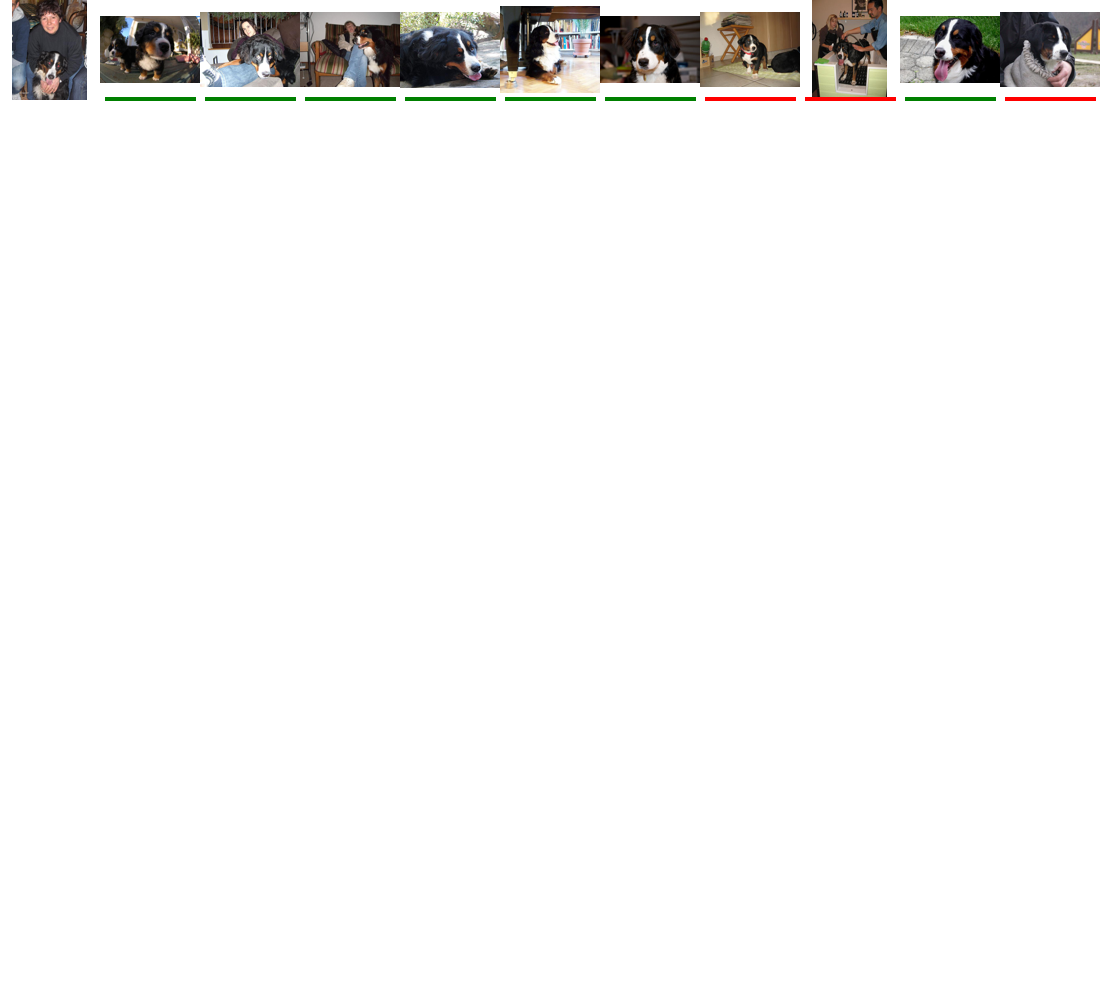

image name query: n02107683_2305.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 5.842467784881592


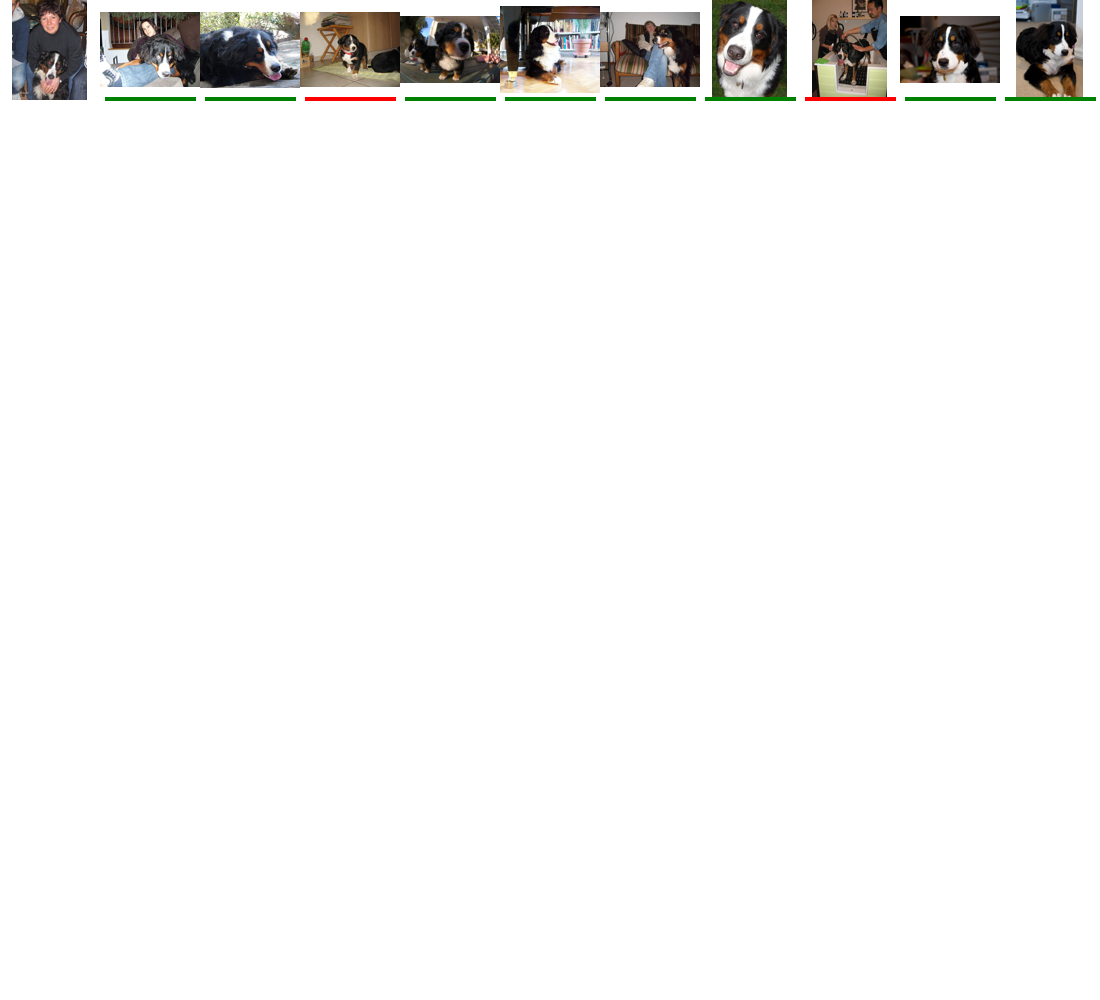

image name query: n02107683_2305.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/1/[1][1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/2/[0][4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/3/[3][1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/4/[-9][-1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/5/[-1][11]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/6/[-1][-2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/7/[-5][2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/8/[11][4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/9/[0][-5]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/10/[5][2]
Time for the query execution: 3.8170924186706543


  0%|          | 0/2375 [00:00<?, ?it/s]

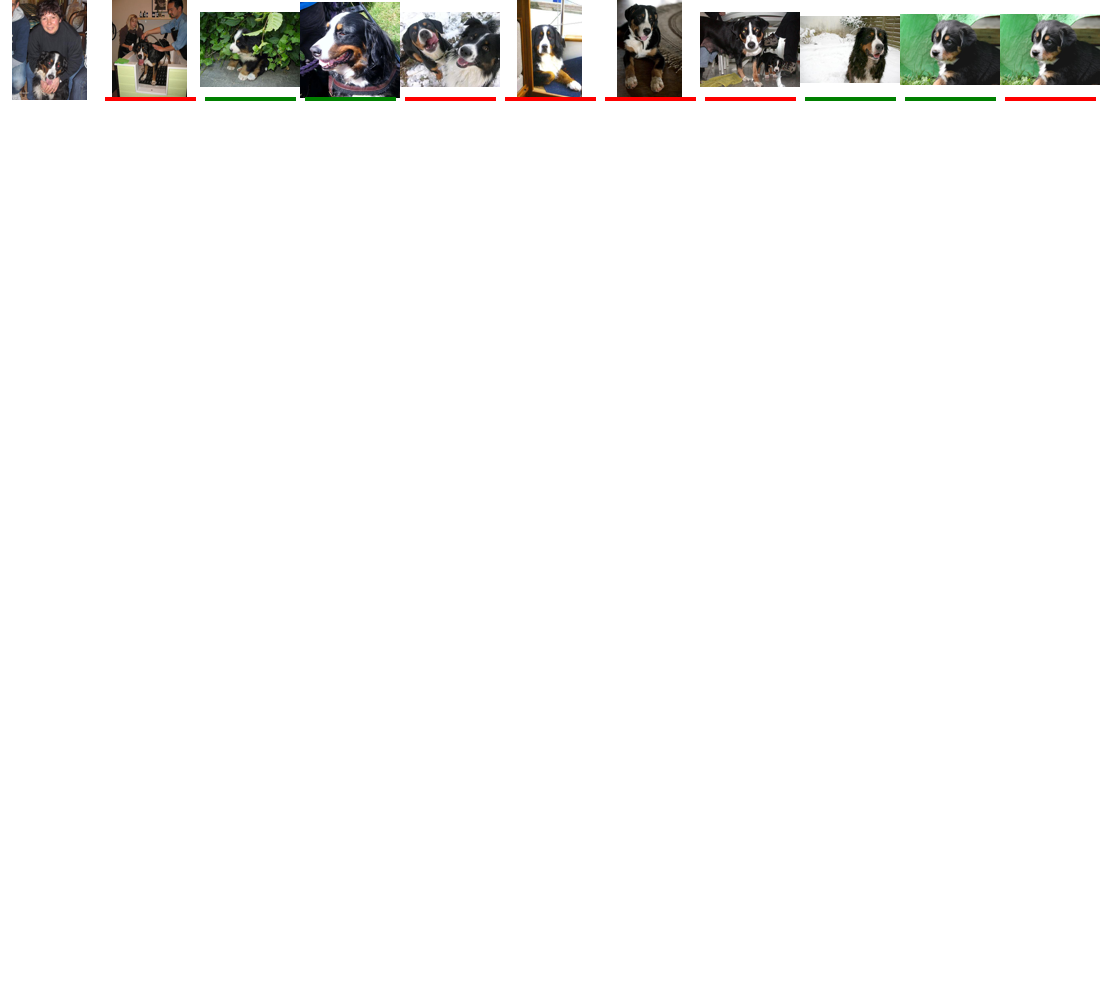

image name query: n02107683_2305.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/1/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/2/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/3/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/4/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/5/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/6/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/7/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/8/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/9/[0 0 0 ... 0 0 0][0 0 0 ...

0it [00:00, ?it/s]

SystemError: ignored

<PIL.Image.Image image mode=RGB size=1100x0 at 0x7F6472862A90>

image name query: n02109961_131.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 5.397584438323975


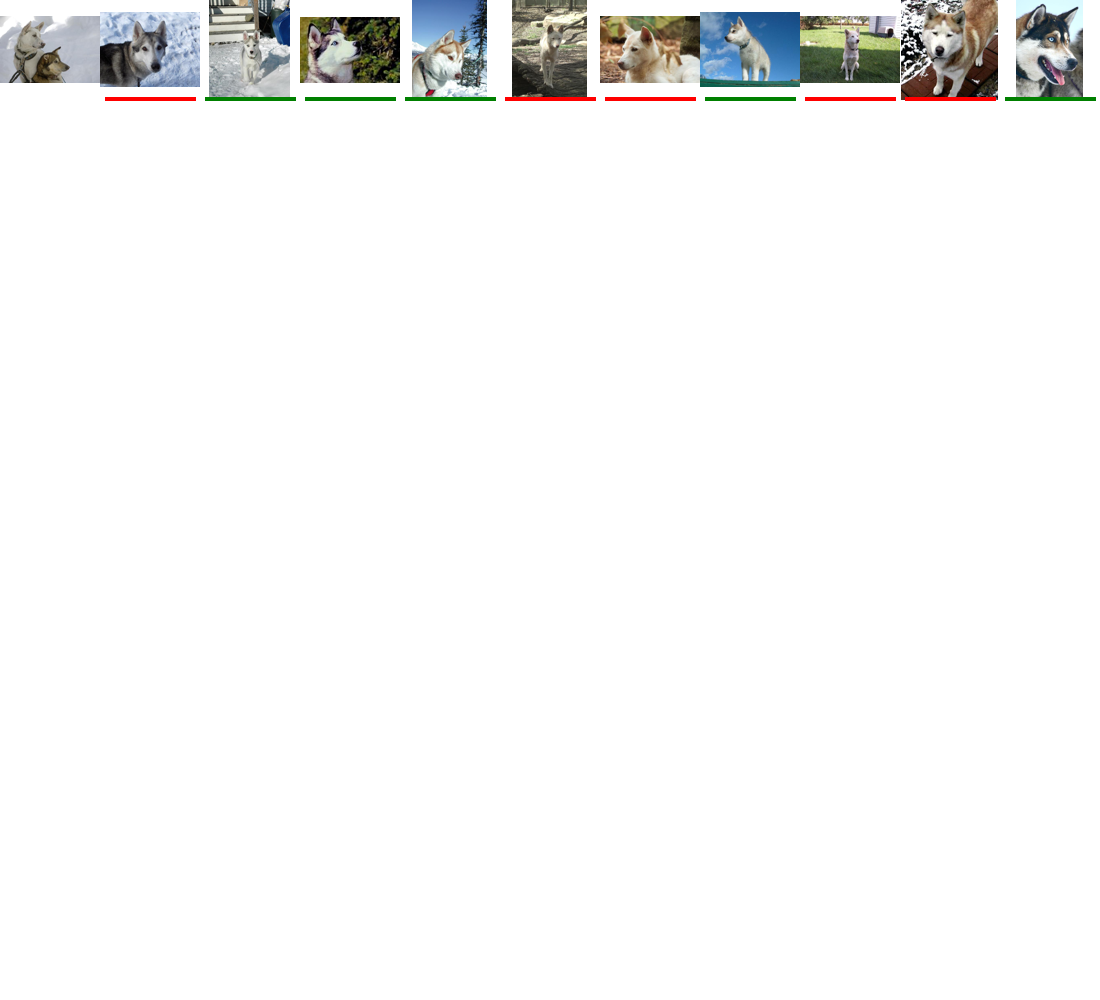

image name query: n02109961_131.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 5.455587387084961


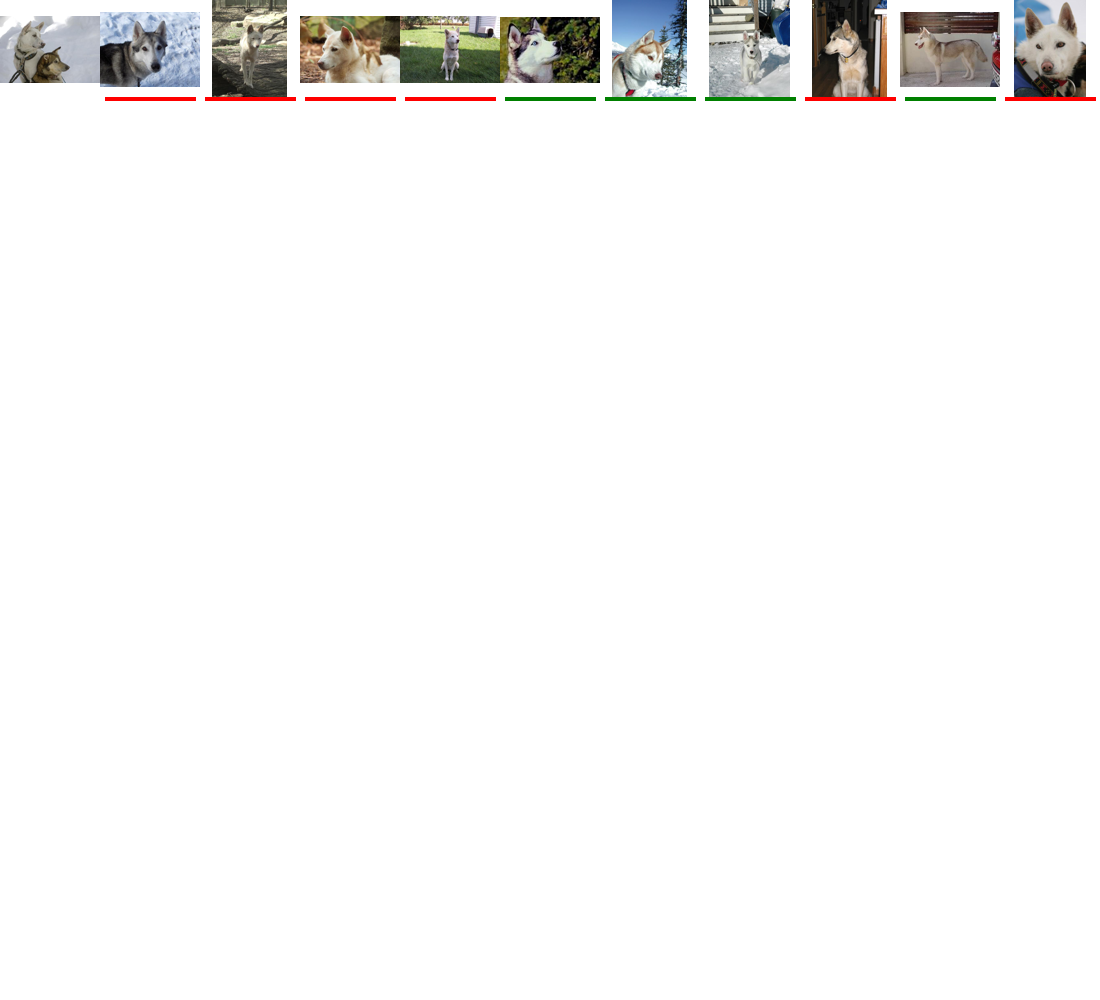

image name query: n02109961_131.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/1/[-4][7]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/2/[2][1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/3/[1][-4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/4/[-15][3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/5/[-6][10]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/6/[-11][3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/7/[-1][1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/8/[7][-1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/9/[1][-3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/10/[14][-1]
Time for the query execution: 3.6592352390289307


  0%|          | 0/1445 [00:00<?, ?it/s]

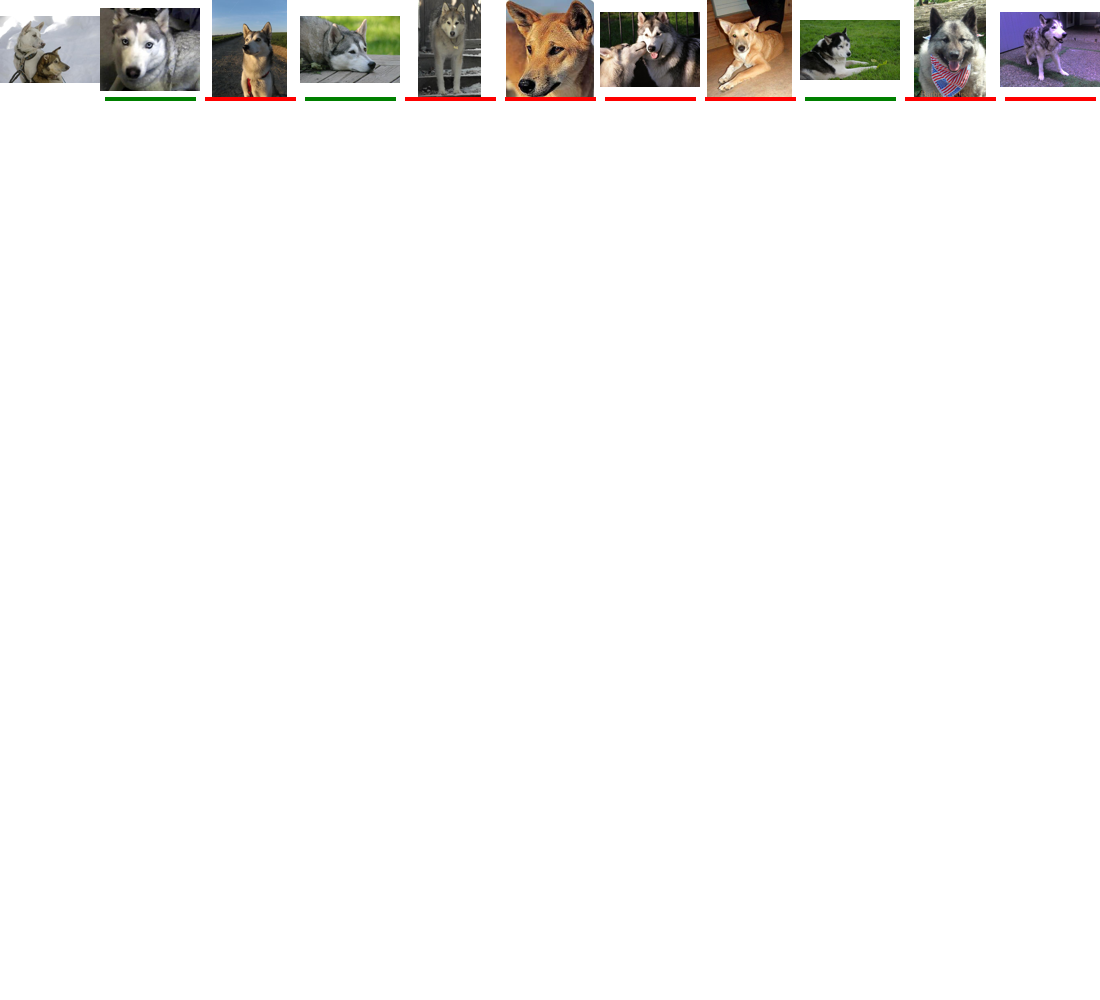

image name query: n02109961_131.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/1/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/2/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/3/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/4/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/5/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/6/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/7/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/8/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/9/[0 0 0 ... 0 0 0][0 0 0 ...

0it [00:00, ?it/s]

SystemError: ignored

<PIL.Image.Image image mode=RGB size=1100x0 at 0x7F647287E650>

image name query: n02111277_7377.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.20309591293335


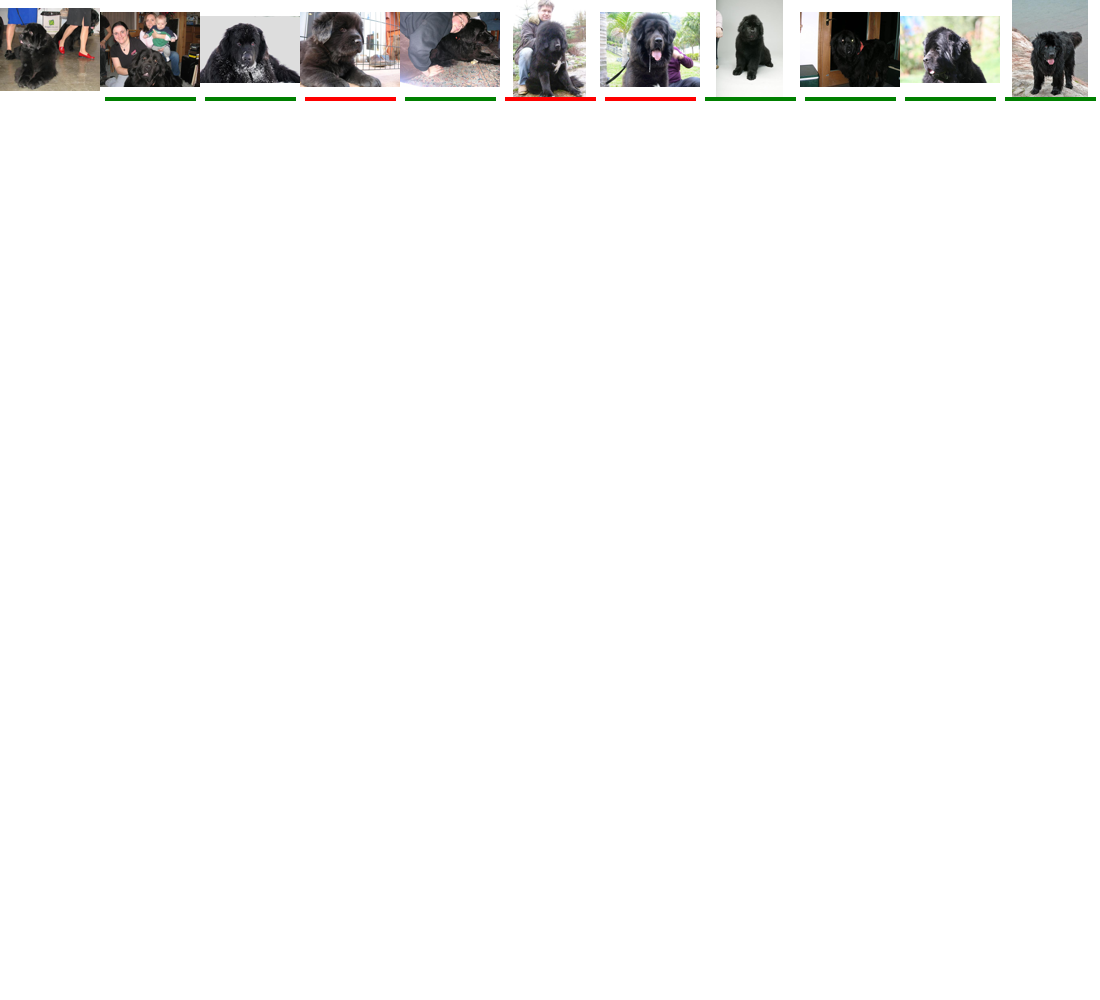

image name query: n02111277_7377.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.446823835372925


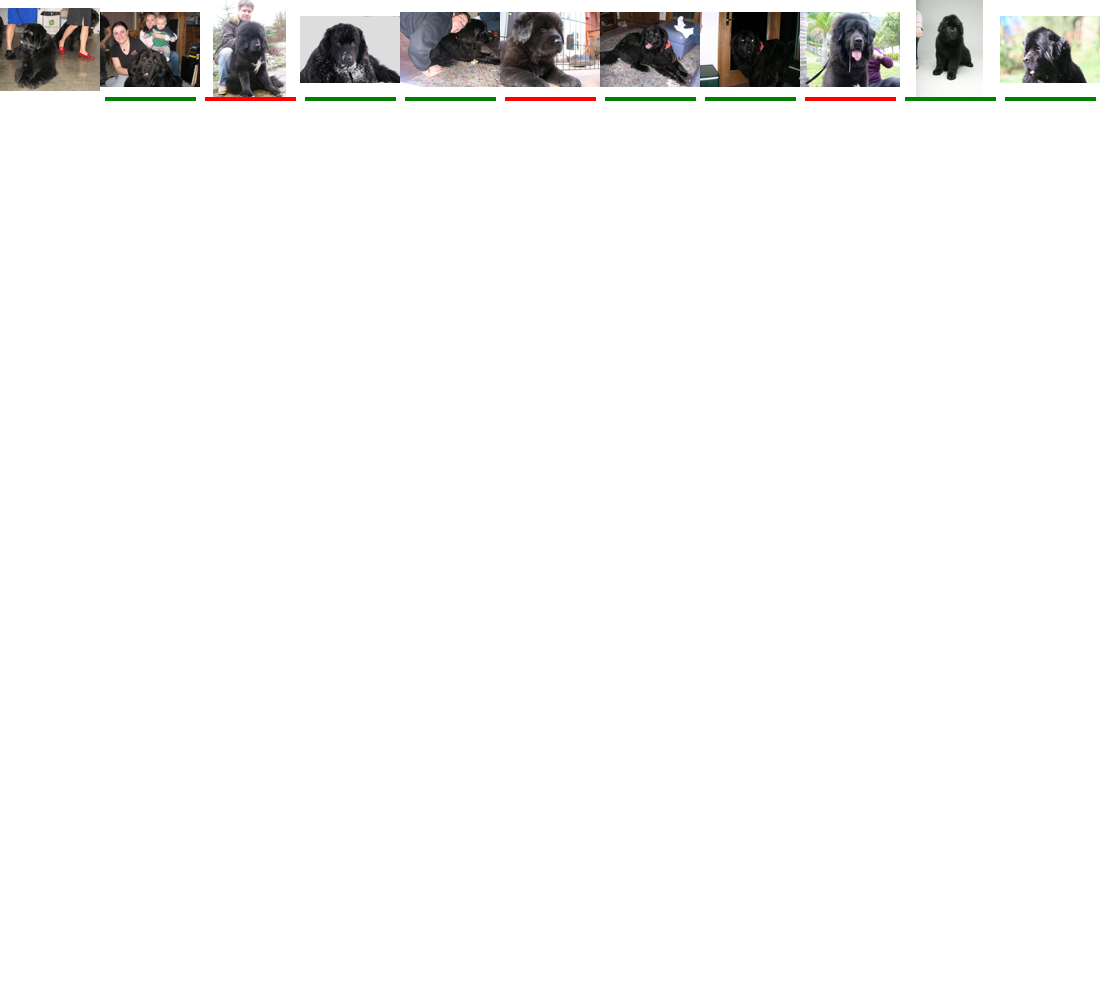

image name query: n02111277_7377.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/1/[-7][9]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/2/[12][-2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/3/[5][-3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/4/[-7][-2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/5/[0][8]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/6/[-8][-14]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/7/[5][-8]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/8/[11][-5]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/9/[-7][-8]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/10/[7][-9]
Time for the query execution: 3.819066047668457


  0%|          | 0/1620 [00:00<?, ?it/s]

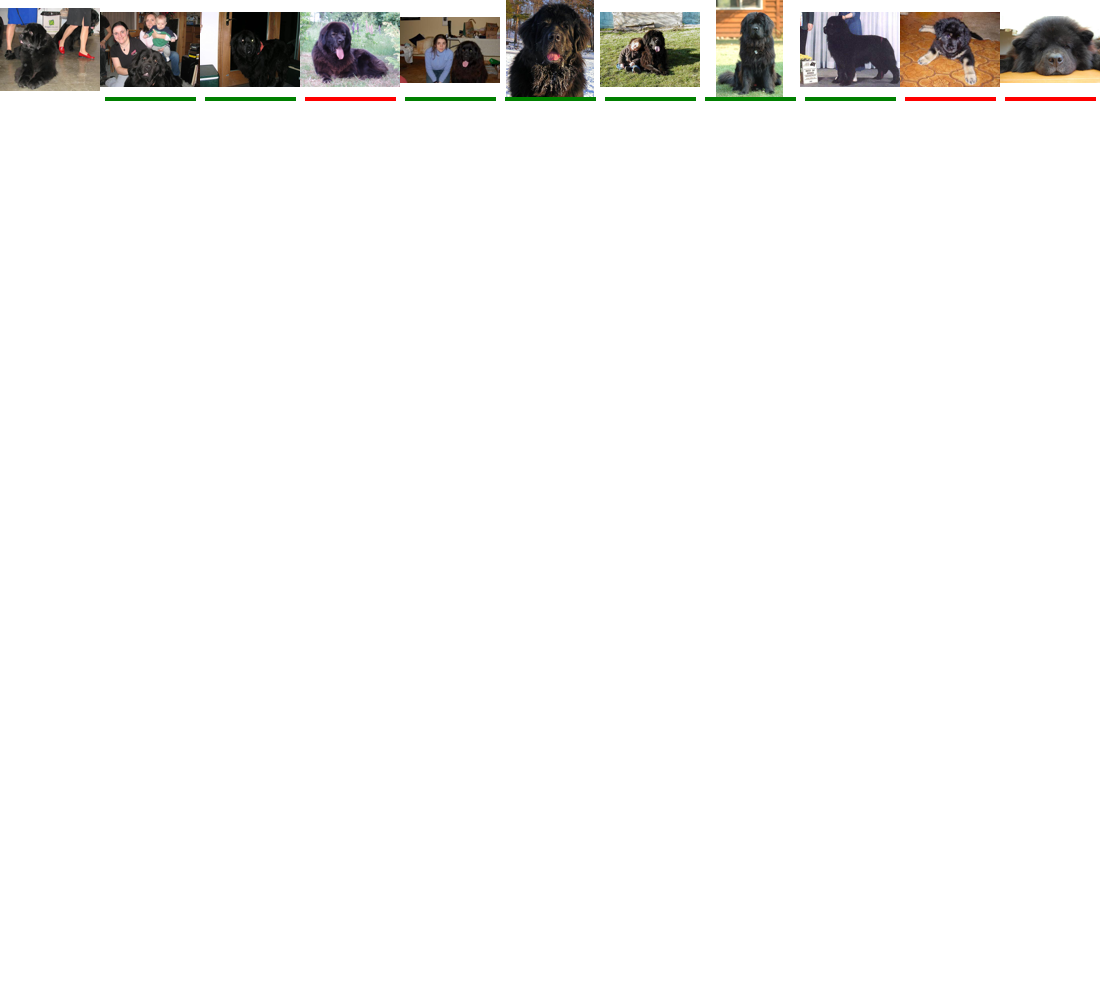

image name query: n02111277_7377.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/1/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/2/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/3/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/4/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/5/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/6/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/7/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/8/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/9/[0 0 0 ... 0 0 0][0 0 0 ...

0it [00:00, ?it/s]

SystemError: ignored

<PIL.Image.Image image mode=RGB size=1100x0 at 0x7F6472CA9BD0>

image name query: n02100236_3782.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 7.041541814804077


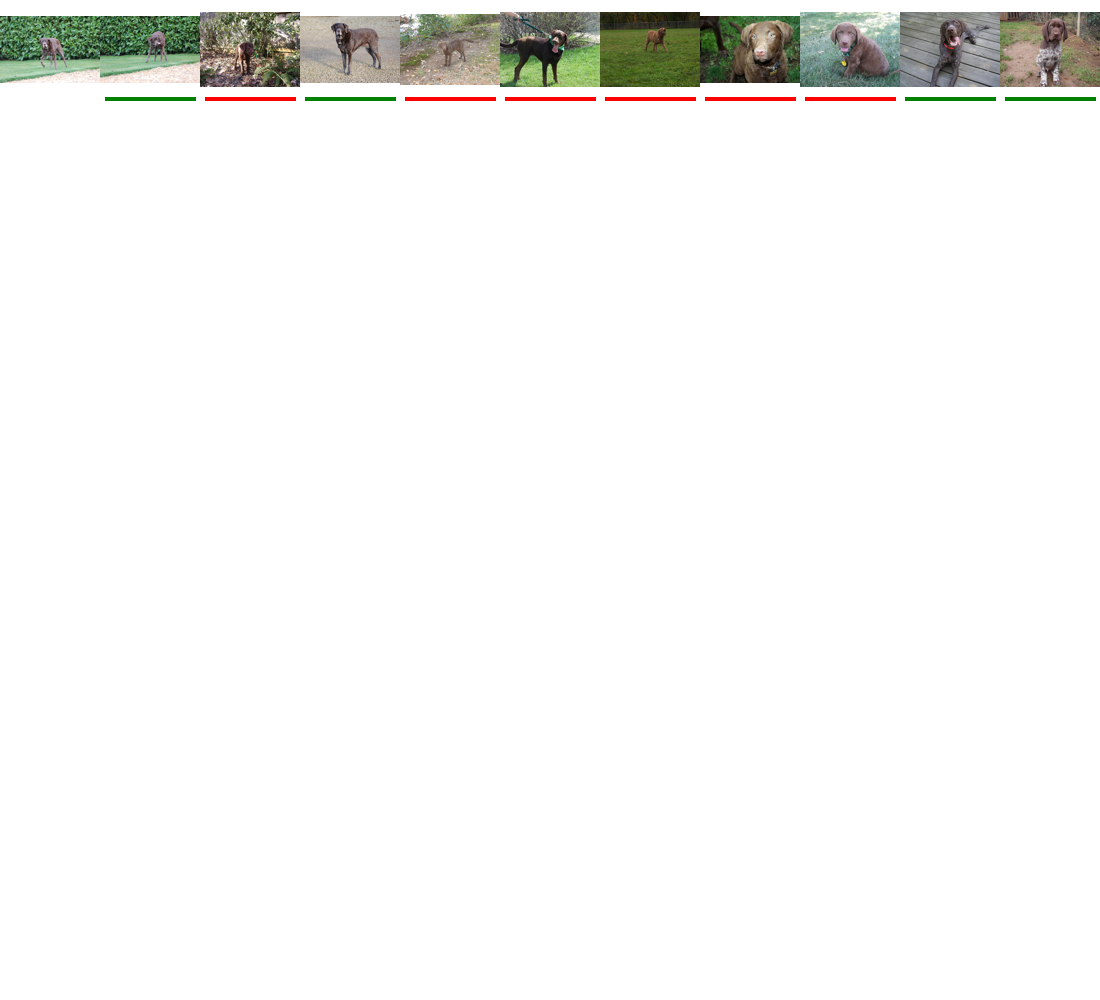

image name query: n02100236_3782.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.819483518600464


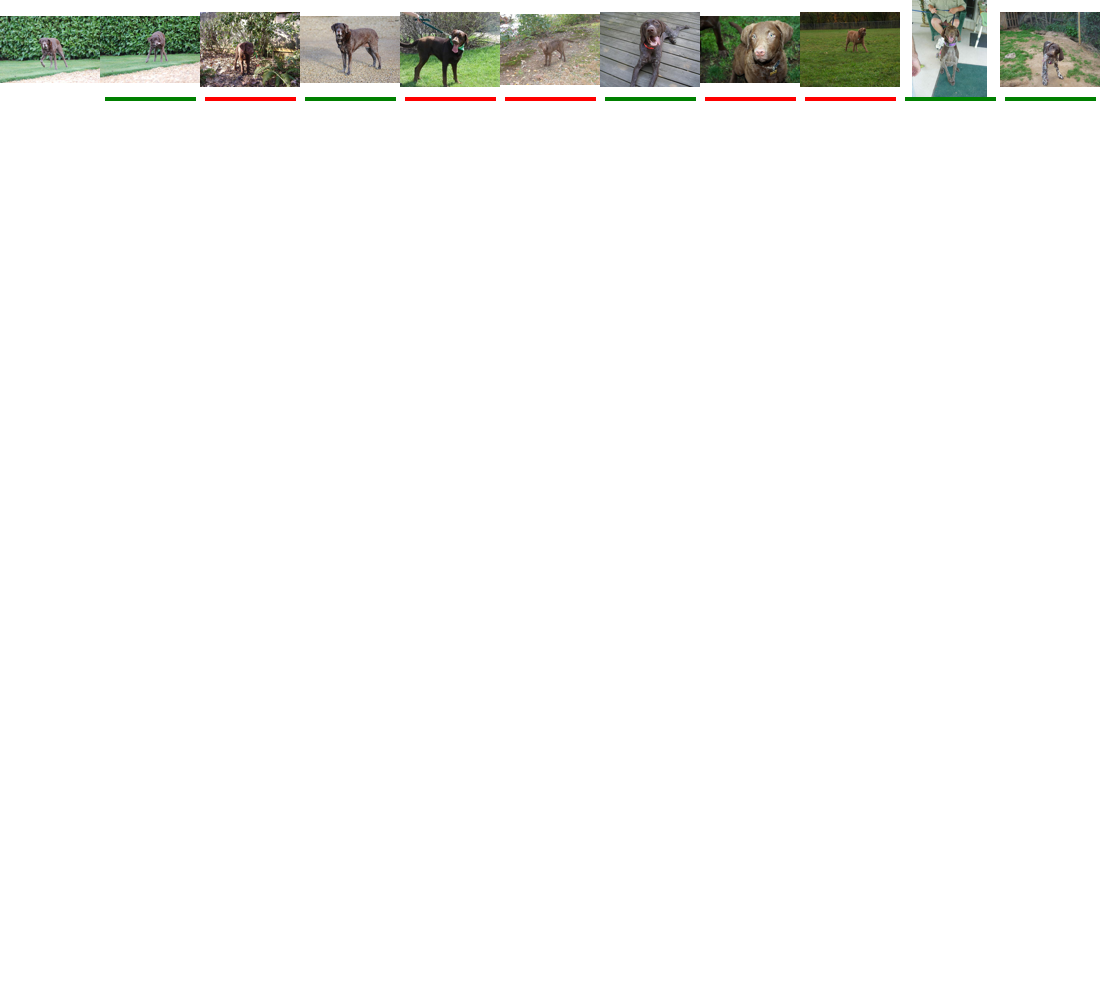

image name query: n02100236_3782.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/1/[-6][2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/2/[-3][19]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/3/[0][4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/4/[-6][4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/5/[8][17]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/6/[-4][-1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/7/[0][4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/8/[10][3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/9/[1][-13]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/10/[1][-8]
Time for the query execution: 3.7305004596710205


  0%|          | 0/1213 [00:00<?, ?it/s]

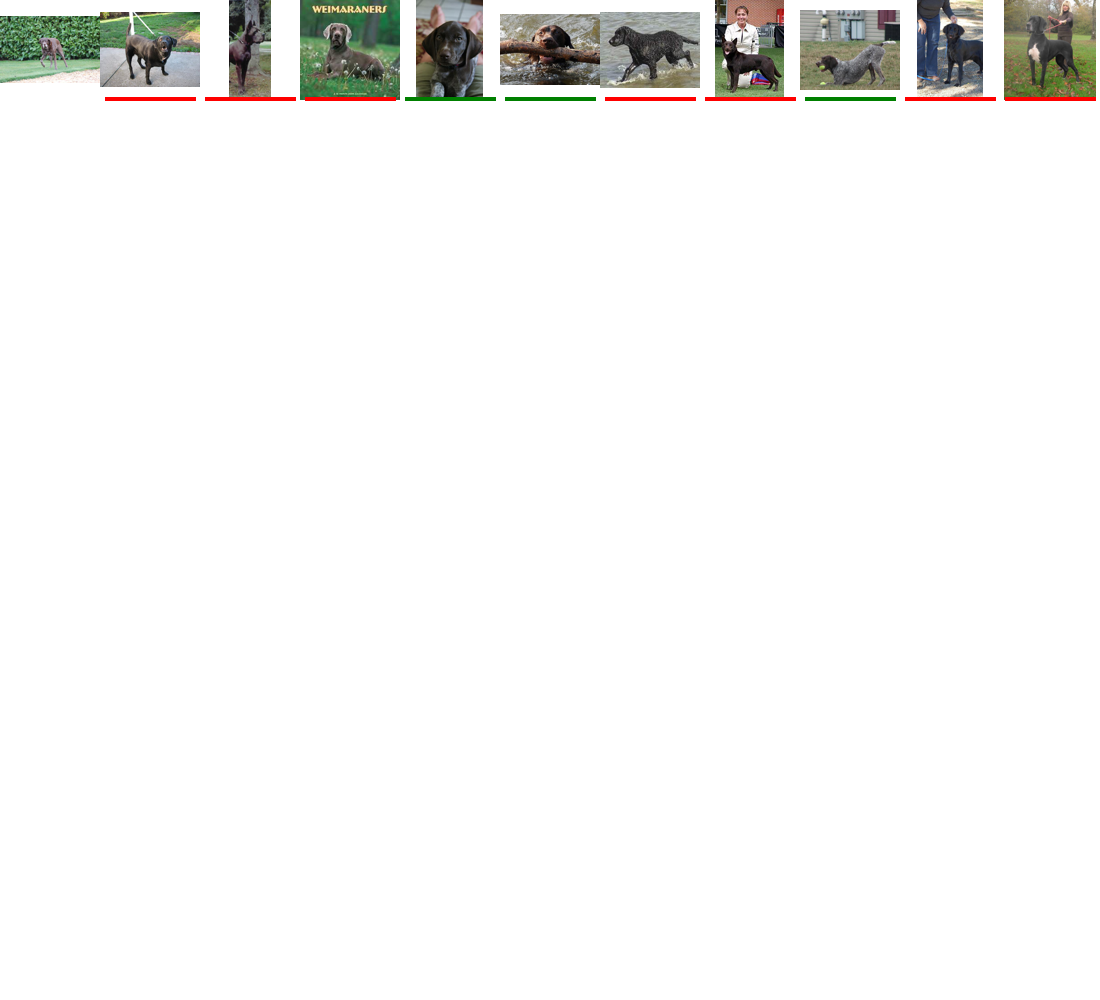

image name query: n02100236_3782.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/1/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/2/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/3/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/4/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/5/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/6/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/7/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/8/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/9/[0 0 0 ... 0 0 0][0 0 0 ...

0it [00:00, ?it/s]

SystemError: ignored

<PIL.Image.Image image mode=RGB size=1100x0 at 0x7F64728F2A10>

image name query: n02097474_7132.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.85395884513855


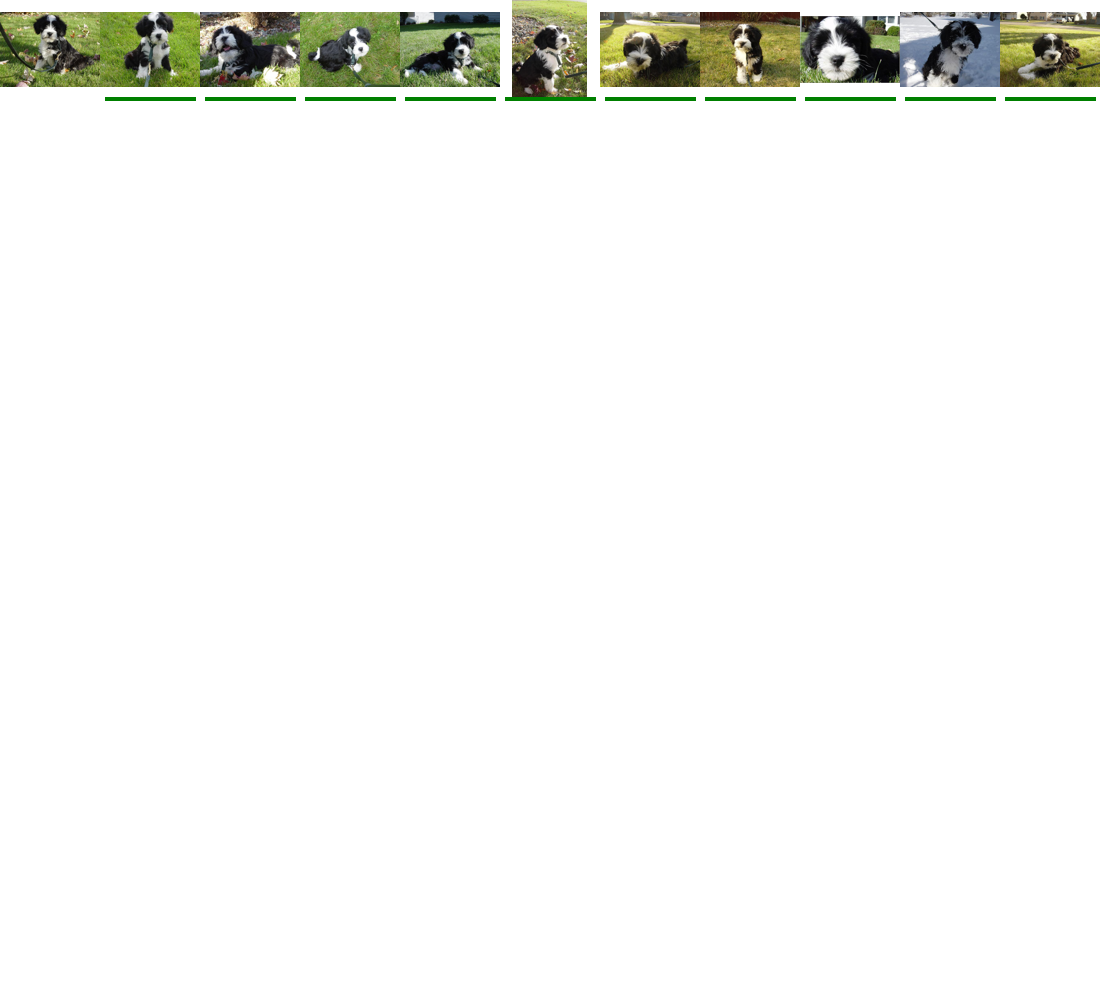

image name query: n02097474_7132.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

Time for the query execution: 6.727127313613892


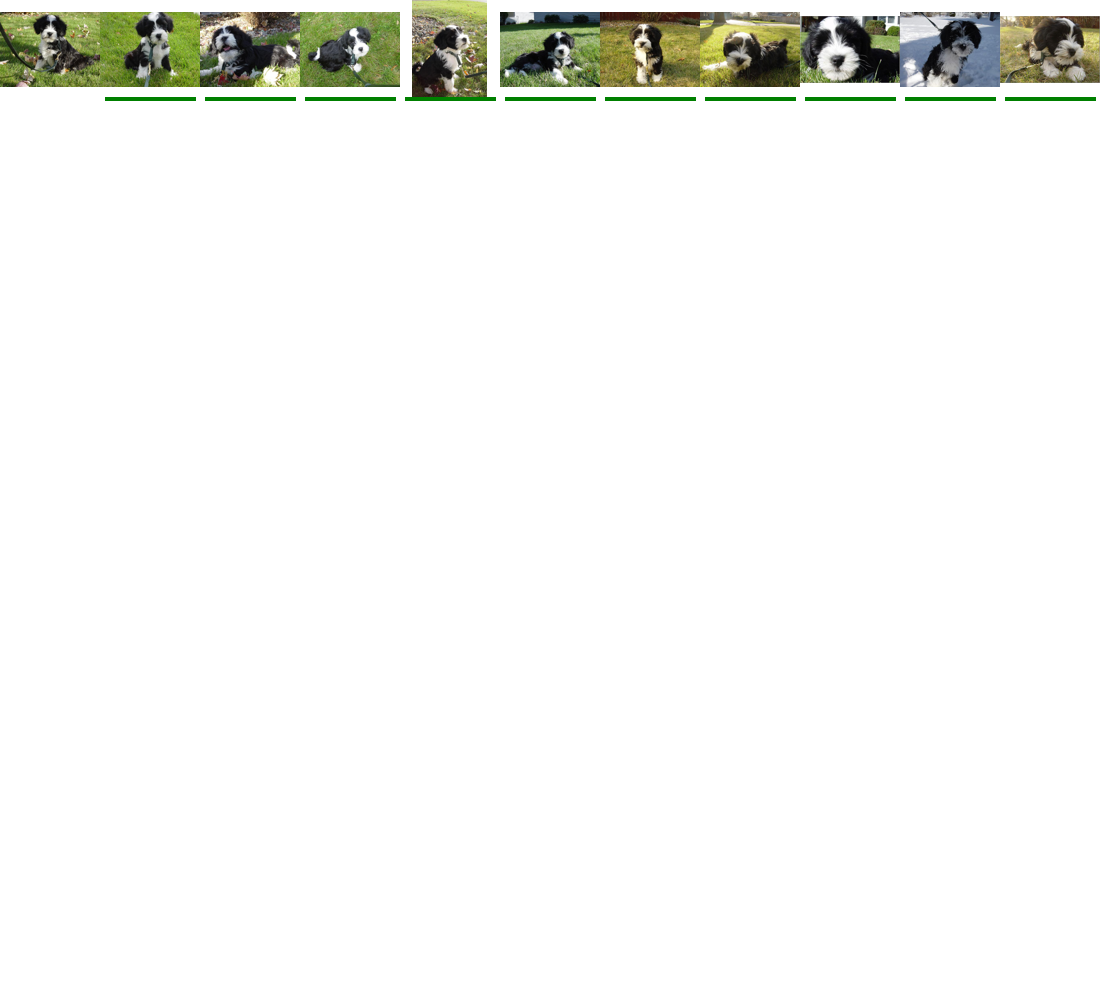

image name query: n02097474_7132.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/1/[-6][10]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/2/[4][-1]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/3/[1][-8]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/4/[-14][-4]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/5/[2][7]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/6/[-2][0]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/7/[0][0]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/8/[10][-2]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/9/[4][-3]
/content/gdrive/Shareddrives/Dataset/Buckets/bucketsG10H2/10/[-5][-5]
Time for the query execution: 3.796386480331421


  0%|          | 0/2434 [00:00<?, ?it/s]

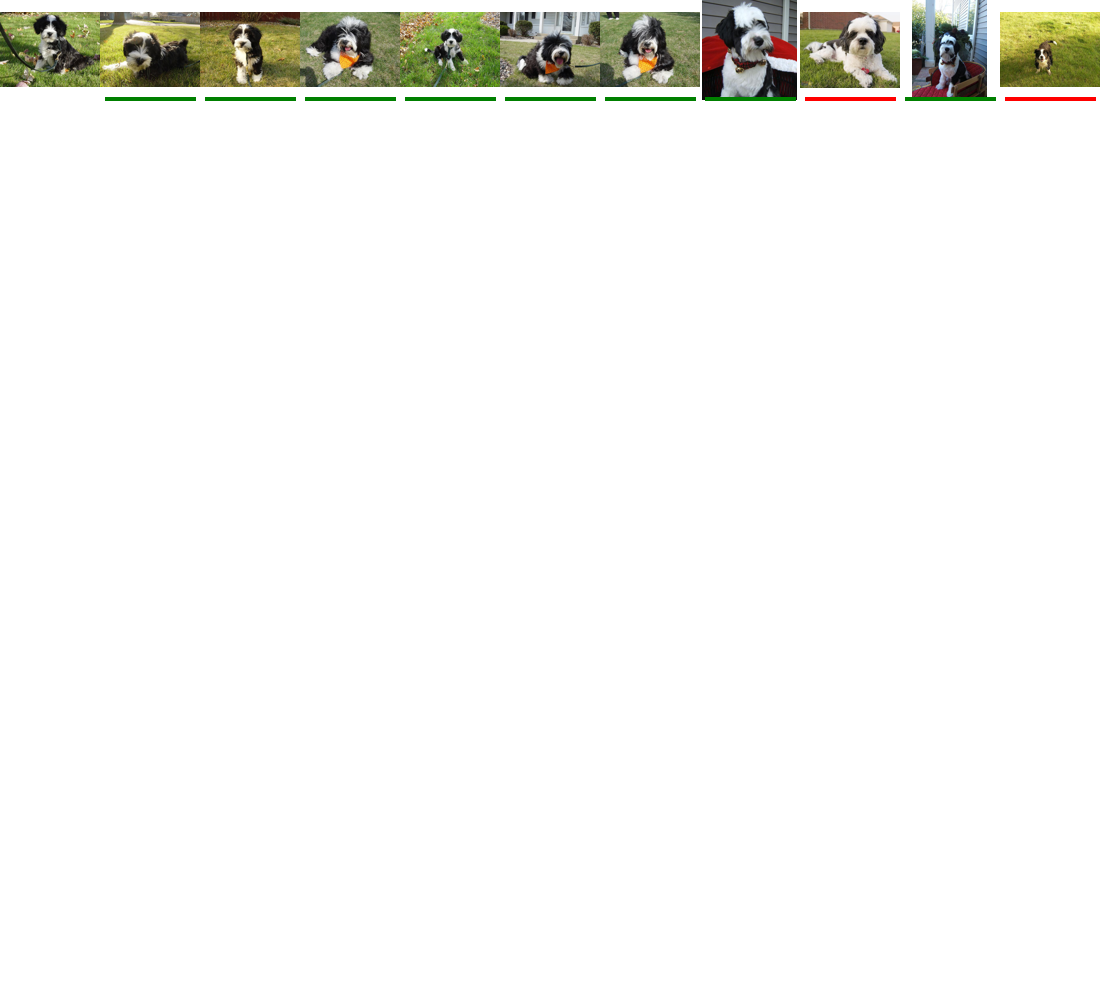

image name query: n02097474_7132.jpg


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


  0%|          | 0/44580 [00:00<?, ?it/s]

/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/1/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/2/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/3/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/4/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/5/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/6/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/7/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/8/[0 0 0 ... 0 0 0][0 0 0 ... 0 0 0]
/content/gdrive/Shareddrives/Dataset/Buckets/FinetunedBuckets/bucketsG10H2/9/[0 0 0 ... 0 0 0][0 0 0 ...

0it [00:00, ?it/s]

SystemError: ignored

<PIL.Image.Image image mode=RGB size=1100x0 at 0x7F6472929C10>

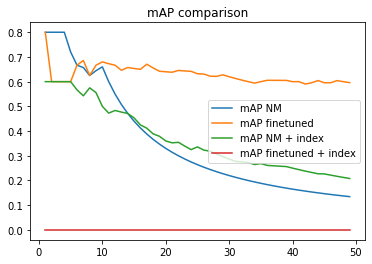

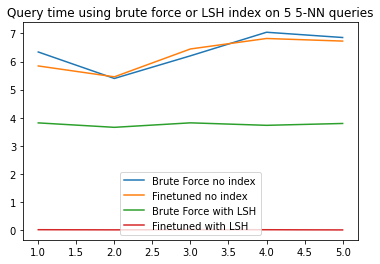

<Figure size 432x288 with 0 Axes>

In [33]:
def query_loop_execution(num_of_queries):

  query_extracted = rand.sample(os.listdir(TEST_PATH), num_of_queries)

  QUERY_TIMES_NM_NO_INDEX = []
  QUERY_MAP_NM_NO_INDEX = []

  QUERY_TIMES_FINETUNED_NO_INDEX = []
  QUERY_MAP_FINETUNED_NO_INDEX = []

  QUERY_TIMES_NM_INDEX = []
  QUERY_MAP_NM_INDEX = []

  QUERY_TIMES_FINETUNED_INDEX = []
  QUERY_MAP_FINETUNED_INDEX = []

  K = 50

  for query_img in query_extracted: 
    res = search_and_print_NM_no_index(query_img, QUERY_TIMES_NM_NO_INDEX)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_NM_NO_INDEX.append(MAP)

    res = search_and_print_finetuned_no_index(query_img, QUERY_TIMES_FINETUNED_NO_INDEX)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_FINETUNED_NO_INDEX.append(MAP)

    res = search_and_print_NM_index(10, 2, query_img, QUERY_TIMES_NM_INDEX, False)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_NM_INDEX.append(MAP)

    res = search_and_print_finetuned_index(10, 2, query_img, QUERY_TIMES_FINETUNED_INDEX, False)
    MAP = []
    for i in range(1, K):
      MAP.append(mAP_calculation(res, query_img, i))
    QUERY_MAP_FINETUNED_INDEX.append(MAP)

  plot_query_map(QUERY_MAP_NM_NO_INDEX, QUERY_MAP_FINETUNED_NO_INDEX, QUERY_MAP_NM_INDEX, QUERY_MAP_FINETUNED_INDEX)
  plot_query_times(num_of_queries, QUERY_TIMES_NM_NO_INDEX, QUERY_TIMES_FINETUNED_NO_INDEX, QUERY_TIMES_NM_INDEX, QUERY_TIMES_FINETUNED_INDEX)

query_loop_execution(5)